In [1]:
from noisy_outlier import NoisyOutlierDetector
from noisy_outlier.model.transformer import IterativeNoiseTransformer, _get_labels as get_labels
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 16, 10
sns.set(style='white')

def LoOPData():
    import pandas as pd
    df = pd.read_csv('https://raw.githubusercontent.com/elki-project/elki/master/data/synthetic/LoOP-publication/multiple-gaussian-2d/multiple-gaussian-2d.csv', sep=' ', comment='#', header=None)
    df.columns = [0, 1, 'y']
    X = df[[0, 1]].values
    y = df['y'].replace({'Cluster1': 0, 'Cluster2': 0, 'Cluster3': 0, 'Noise': 1})
    return X, y


def plot(X_pos, X_neg=None, show=True):
    plt.scatter(X_pos[:, 0], X_pos[:, 1], c='green')
    if X_neg is not None:
        plt.scatter(X_neg[:, 0], X_neg[:, 1], c='red')
    if show:
        plt.show()


X, y = LoOPData()

In [2]:
tr = IterativeNoiseTransformer(n_sampling_iter=5)

In [3]:
tr.fit(X)

IterativeNoiseTransformer(n_sampling_iter=5)

In [4]:
n = tr.transform(X)

In [5]:
data = pd.DataFrame(n, columns=['x', 'y'])
data['type of point'] = list(map(lambda x: '$\widetilde{N}$' if x == 1 else '$X$', get_labels(X.shape[0], n.shape[0])))

# Plots for illustration

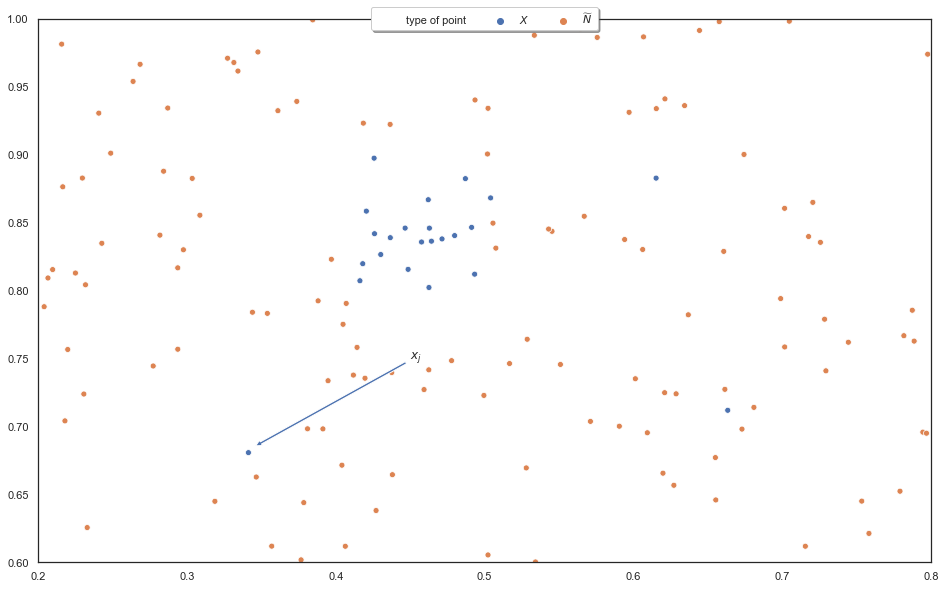

In [6]:
s = sns.scatterplot('x', 'y', data=data, hue='type of point')
plt.xlabel(''), plt.ylabel('')
s.set(ylim=(0.6, 1), xlim=(0.2, 0.8))
s.axes.xaxis.limit_range_for_scale(0.2, 0.8)
_ = s.axes.yaxis.limit_range_for_scale(0.6, 1)

_ = plt.annotate('$x_j$', xy=(0.345, 0.685), xytext=(0.45, 0.75), arrowprops={'arrowstyle': 'simple'})

plt.legend(loc='center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)

plt.savefig("./plots/xj_outlier.pdf", dpi=300)

In [7]:
model = NoisyOutlierDetector()

In [8]:
model.fit(X)

NoisyOutlierDetector()

In [9]:
data = pd.DataFrame(X, columns=['x', 'y'])
data['outlier probability'] = model.predict_outlier_probability(X)

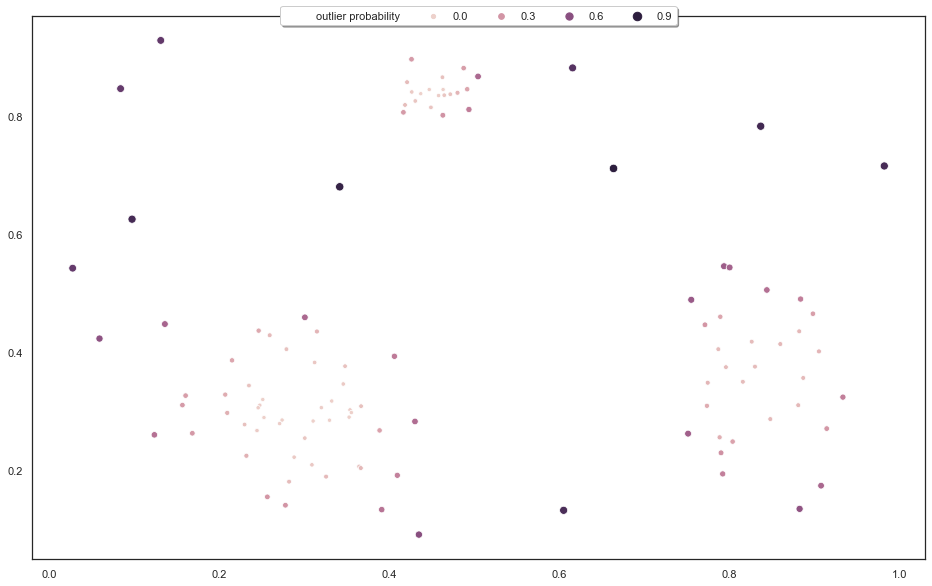

In [10]:
s = sns.scatterplot('x', 'y', data=data, hue='outlier probability', size='outlier probability')
_ = plt.xlabel(''), plt.ylabel('')

plt.legend(loc='center', bbox_to_anchor=(0.5, 1.0), ncol=5, fancybox=True, shadow=True)

plt.savefig("./plots/results_algorithm_2.pdf", dpi=300)

# Plots for results

In [11]:
files = ['HeartDisease_withoutdupl_norm_05_v10', 'Stamps_withoutdupl_norm_05_v10', 'WPBC_withoutdupl_norm', 'Lymphography_withoutdupl_norm_idf']

In [12]:
def load_file(f: str):
    df = pd.read_csv(f'./results/{f}.csv', index_col=0, header=[0, 1])
    dataname = f.split('_')[0]
    m = 'roc_auc_dec_func'
    df = df.xs(m, level=1, axis=1)
    df = df.rename(columns={'NoisyOutlierDetector': 'Ours'})
    return dataname, df

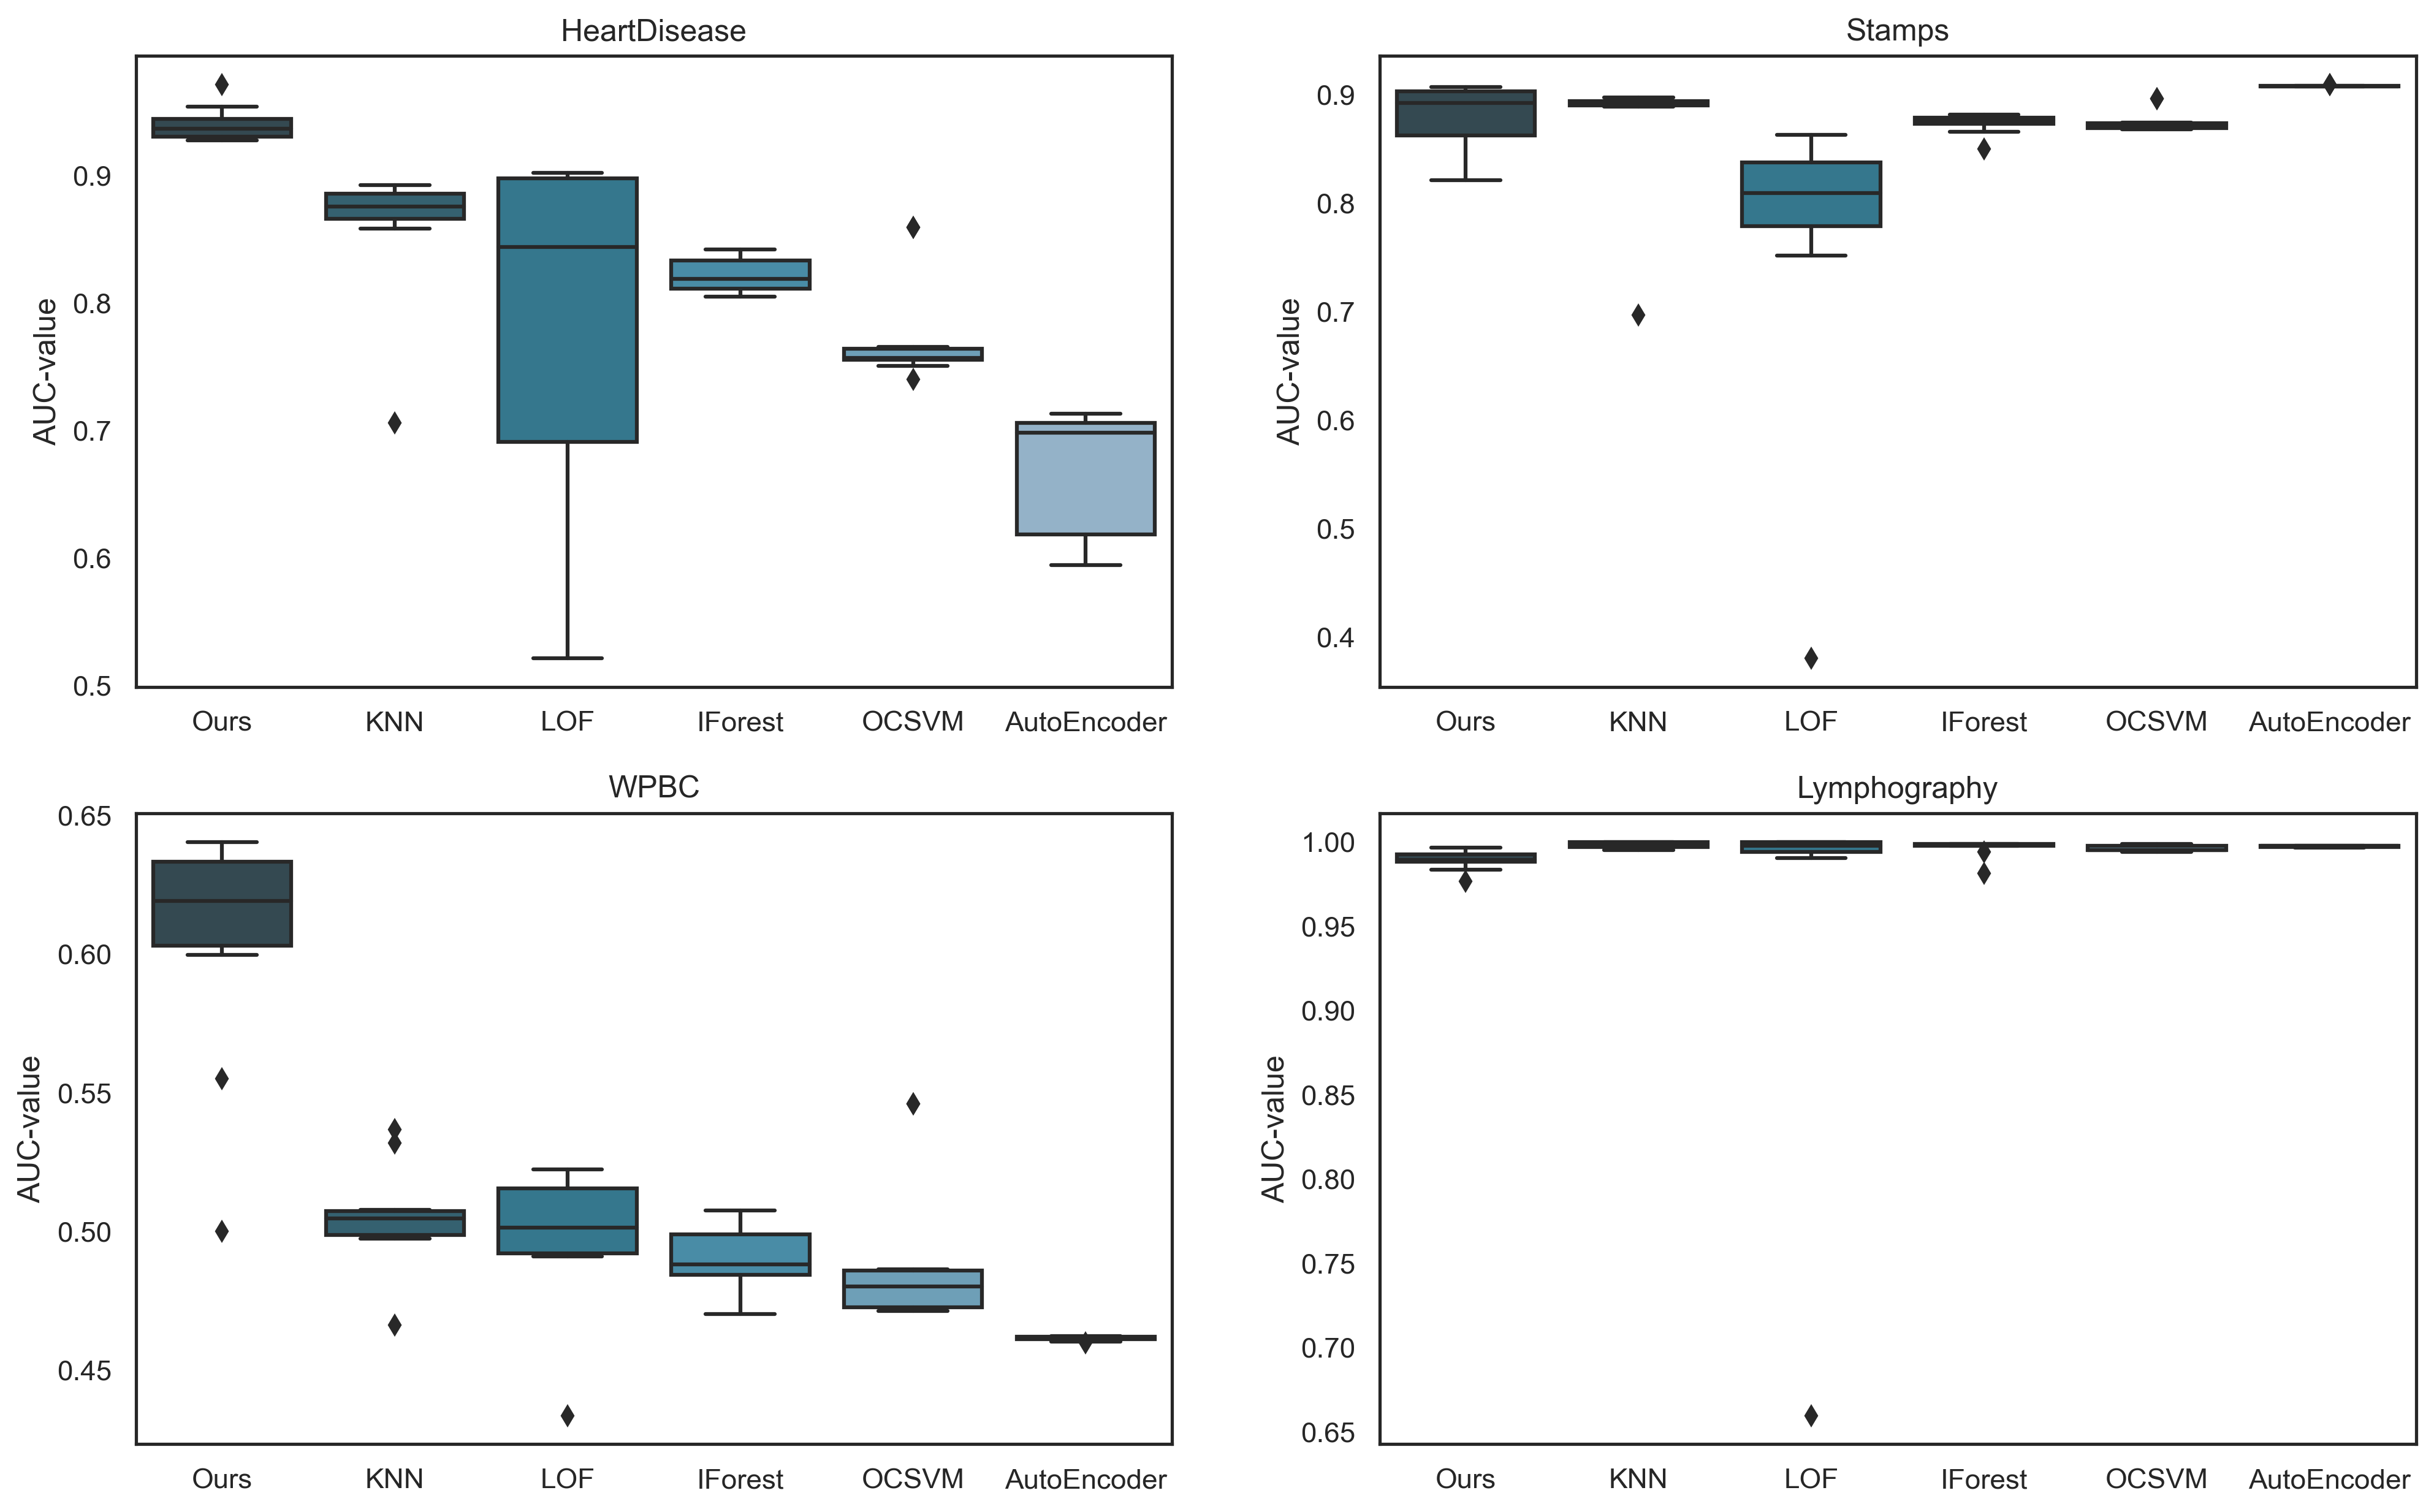

In [13]:
plt.rcParams['figure.figsize'] = 16, 10
f, axes = plt.subplots(2, 2, sharex=False, sharey=False, dpi=300)
axes = axes.ravel()

for ax, file in zip(axes, files):
    dataname, df = load_file(file)
    sns.boxplot(x="dataset", y="AUC-value", data=pd.melt(df, var_name='dataset', value_name='AUC-value'), 
                palette='PuBuGn_d', ax=ax)
    ax.set_title(dataname)
    ax.set_xlabel('')
    
plt.savefig("./plots/results_no_artificial.pdf", dpi=300)

In [14]:
files = ['HeartDisease', 'Lymphography', 'Stamps', 'WPBC']

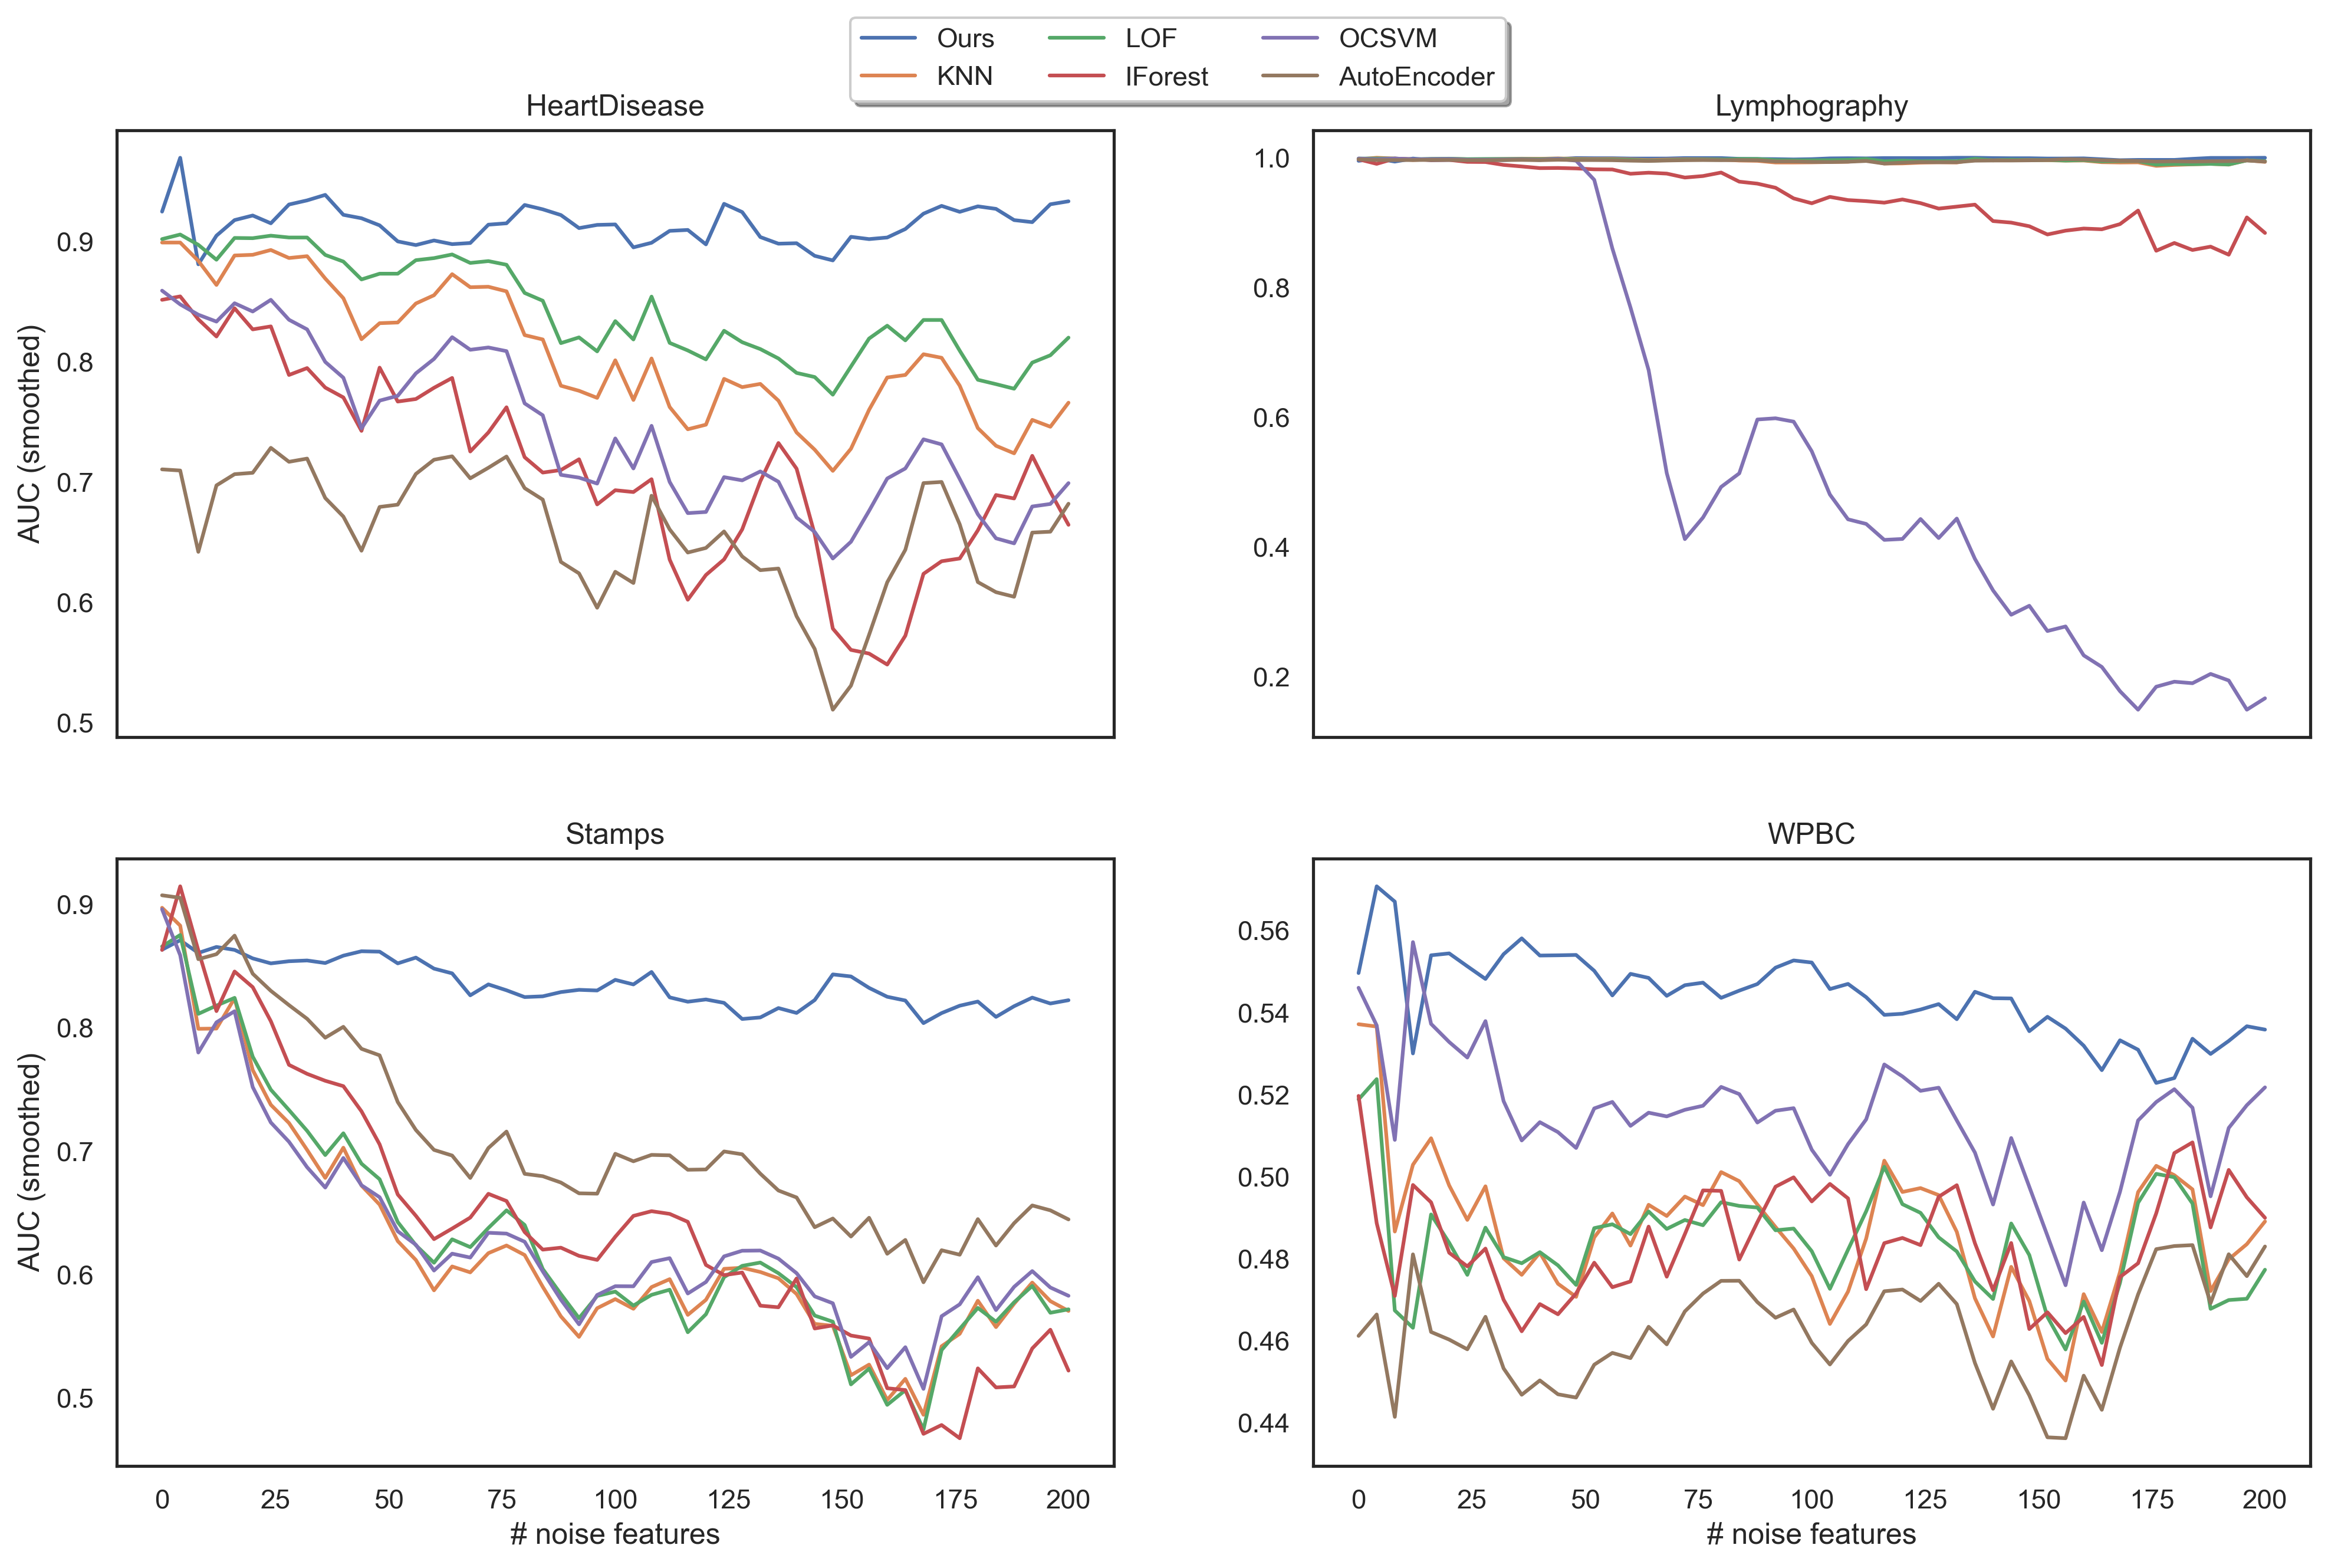

In [15]:
plt.rcParams['figure.figsize'] = 16, 10
f, axes = plt.subplots(2, 2, sharex=True, sharey=False, dpi=300)
axes = axes.ravel()

for i, (ax, file) in enumerate(zip(axes, files)):
    df = pd.read_csv(f'./results/with_noisy_features/{file}.csv', index_col=0)
    m = df.columns
    
    smooth = 5
    df = pd.concat([df.iloc[:smooth-1, :], df.rolling(smooth).mean().dropna()])
    
    df = df.unstack().reset_index()
    df.columns = ['model', 'n_noise_features', 'AUC']
    sns.lineplot(x='n_noise_features', y='AUC', hue='model', data=df, 
                    palette=None, ax=ax)

    
    ax.set_title(file)
    ax.set_xlabel('# noise features')
    
    if i % 2 == 0:
        ax.set_ylabel('AUC (smoothed)')
    else:
        ax.set_ylabel('')
    ax.get_legend().remove()

# f.legend(m, loc='right')
f.legend(m, loc='center', bbox_to_anchor=(0.5, 0.92), ncol=3, fancybox=True, shadow=True)

    
plt.savefig("./plots/results_with_artificial.pdf")